In [1]:
print("hello")

hello


In [2]:
import pandas as pd

In [3]:
filepath = "filtered_NSEI.csv"
data_NSEI = pd.read_csv(filepath)
data_NSEI = data_NSEI.sort_values("Date")
data_NSEI.head()


,Date,Open,High,Low,Close,Volume,Name
0,2014-04-25,6855.799805,6869.850098,6772.850098,6782.750000,154300,NSEI
1,2014-04-28,6778.549805,6786.250000,6750.299805,6761.250000,118200,NSEI
2,2014-04-29,6769.000000,6779.700195,6708.649902,6715.250000,115500,NSEI
3,2014-04-30,6724.950195,6780.149902,6656.799805,6696.399902,161100,NSEI
4,2014-05-02,6709.950195,6737.649902,6689.500000,6694.799805,114300,NSEI


In [4]:
data_NSEI = data_NSEI.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])


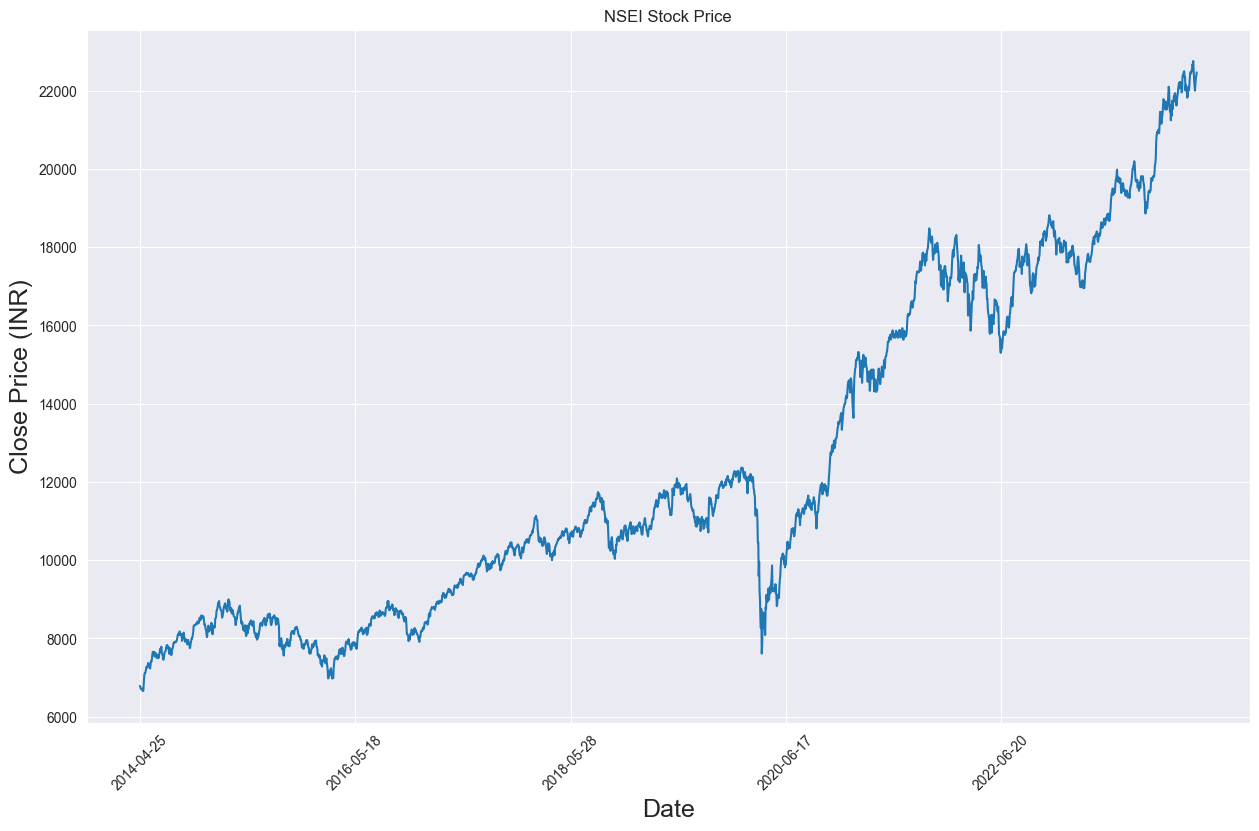

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data_NSEI[["Close"]])
plt.xticks(range(0, data_NSEI.shape[0], 500), data_NSEI["Date"].loc[::500], rotation=45)
plt.title("NSEI Stock Price")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (INR)", fontsize=18)
plt.show()

In [6]:
price_NSEI = data_NSEI[["Close"]]
price_NSEI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2455 non-null   float64
dtypes: float64(1)
memory usage: 19.3 KB


In [7]:
data_NSEI.dropna(inplace=True)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price_NSEI["Close"] = scaler.fit_transform(price_NSEI["Close"].values.reshape(-1, 1))

C:\Users\Bhargav\AppData\Local\Temp\ipykernel_8348\3477268186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_NSEI["Close"] = scaler.fit_transform(price_NSEI["Close"].values.reshape(-1, 1))


In [9]:
import numpy as np

In [10]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [11]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price_NSEI, lookback)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train.shape =  (1948, 19, 1)
y_train.shape =  (1948, 1)
x_test.shape =  (487, 19, 1)
y_test.shape =  (487, 1)


In [12]:
import time

In [13]:
import torch 
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_train).type(torch.Tensor)

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 105

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)

In [17]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4211007058620453
Epoch  1 MSE:  0.15219104290008545
Epoch  2 MSE:  0.09579165279865265
Epoch  3 MSE:  0.13245125114917755
Epoch  4 MSE:  0.07993526756763458
Epoch  5 MSE:  0.04949815943837166
Epoch  6 MSE:  0.05429517477750778
Epoch  7 MSE:  0.05361848324537277
Epoch  8 MSE:  0.031938787549734116
Epoch  9 MSE:  0.007233323063701391
Epoch  10 MSE:  0.008717109449207783
Epoch  11 MSE:  0.025792034342885017
Epoch  12 MSE:  0.015645820647478104
Epoch  13 MSE:  0.004641535226255655
Epoch  14 MSE:  0.011195482686161995
Epoch  15 MSE:  0.016771821305155754
Epoch  16 MSE:  0.011811786331236362
Epoch  17 MSE:  0.0037903543561697006
Epoch  18 MSE:  0.0007945219404064119
Epoch  19 MSE:  0.0038249308709055185
Epoch  20 MSE:  0.007866463623940945
Epoch  21 MSE:  0.008377696387469769
Epoch  22 MSE:  0.005884845275431871
Epoch  23 MSE:  0.003628665814176202
Epoch  24 MSE:  0.0033148343209177256
Epoch  25 MSE:  0.004149877466261387
Epoch  26 MSE:  0.004459132440388203
Epoch  27 MSE:  

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

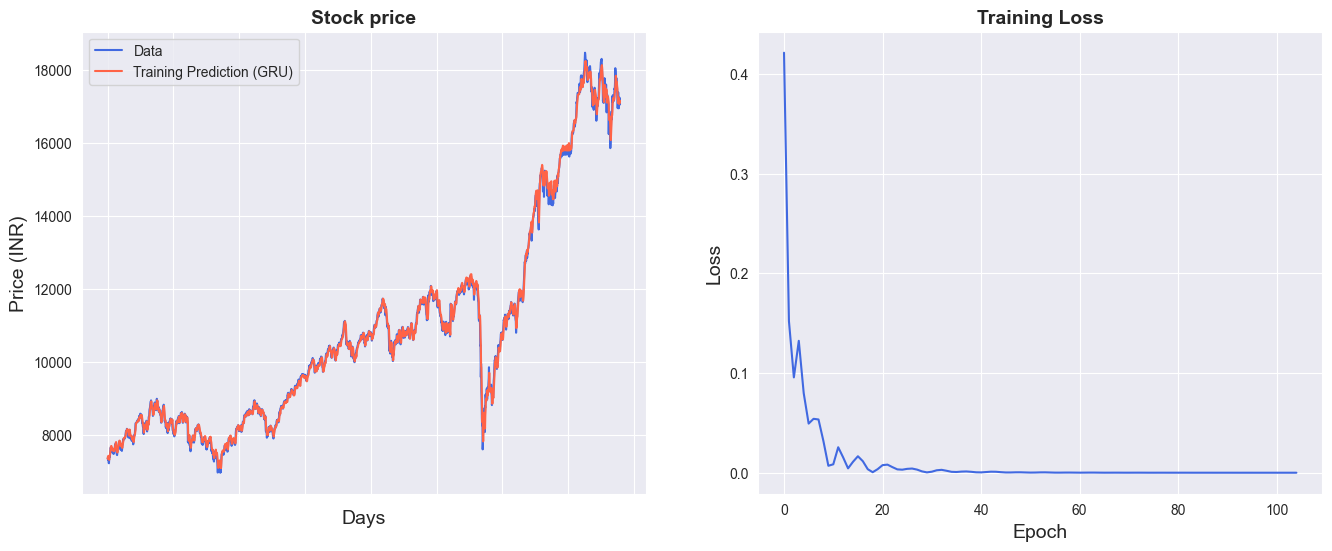

In [19]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (INR)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')

fig.set_figheight(6)
fig.set_figwidth(16)